# Momentum Trading Strategies in Bitcoin

As part of my masters course in Quantitative Finance, I wrote a dissertation which studied market efficiency in cryptocurrencies by testing the profitability of a range of common technical trading strategies. The dissertation can be accessed here:

https://github.com/mmcgarry92/MyDataAnalysis/blob/master/MMcGarry%20Dissertation.pdf

In this workbook, I explore two of the profitable trading strategies found in my dissertation to see if they remained profitable for the two years following my conclusions.

The two strategies to be tested are:
1. Moving Average (MA) Crossover Strategies
2. Trading Range Break (TRB) Strategies

The formation of these strategies is discussed in more detail below - for an in depth description of them see the methodology section of my dissertation.

## Data
First the dataset is imported. It includes the Bitcoin daily closing price every day from June 2018 to June 2020.

In [240]:
import pandas as pd
from pandas_datareader import data
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import numpy as np
from math import exp, expm1
%matplotlib inline

In [241]:
ticker = ['BTC-USD']
start_date = '2018-06-01'
end_date = '2020-06-01'

btc_data = data.get_data_yahoo(ticker,start_date,end_date)

In [242]:
df = btc_data['Adj Close'].copy()

In [243]:
df

Symbols,BTC-USD
Date,
2018-05-31,7541.450195
2018-06-01,7643.450195
2018-06-02,7720.250000
2018-06-03,7514.470215
2018-06-04,7633.759766
...,...
2020-05-28,9439.124023
2020-05-29,9700.414062
2020-05-30,9461.058594


## Moving Average Trading Strategy
A moving average (MA) crossover strategy works by tracking two different length simple moving averages of a time series; one shorter length MA (SMA) and one longer length MA (LMA).

If the value of the SMA crosses above the value of the LMA (i.e. moves from being less than to greater than the LMA) then a buy signal is generated and a long position is opened.

Liekwise, when the value of the SMA then crosses below the value of the LMA (i.e. moves from being greater than to less than the LMA) then a sell signal is generated and a short position is opened.

The dataset is modifed to include the log returns for Bitcoin, as well as the figures for the SMA and (LMA) of the Bitcoin price.

In this case the SMA is equal to 5 days and the LMA equal to 20 days.

In [244]:
df_5_20 = df.copy()
df_5_20['BTC_R'] = np.log(df_5_20['BTC-USD']).diff()
df_5_20['MA_5'] = df['BTC-USD'].rolling(5).mean()
df_5_20['MA_20'] = df['BTC-USD'].rolling(20).mean()

A trading signal is then generated, so that the trading strategy is long Bitcoin when the SMA is greater than the LMA, and short Bitcoin when the SMA is less than the LMA.

However, since the trading signal is generated on the close price of that day, we will only change our positions after the close price has been realised. Therefore our position will only change at the start of the following day. This is easily corrected by lagging the signal values by one day.

For a more in depth description of this reasoning, see: https://www.learndatasci.com/tutorials/python-finance-part-3-moving-average-trading-strategy/#FinalCaveat


In [245]:
df_5_20['signal'] = np.sign(df_5_20['MA_5'] - df_5_20['MA_20'])
df_5_20['signal'] = df_5_20['signal'].shift(1)

C:\Users\Michael\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


The signal is equal to 1 when long and -1 when short.

The strategy returns can then be calculated as the signal multiplied by the log returns of Bitcoin

In [246]:
df_5_20['strategy_r'] = df_5_20['signal'] * df_5_20['BTC_R']

In practice, it can be quite difficult to enter into short positions on cryptocurrencies; so another strategy is formed which only enters into the long portions of this trade and ignores any short selling signals (i.e. holds cash when a short signal is formed).

In [247]:
df_5_20['long'] = df_5_20['signal'] + 1
df_5_20['long'] = np.sign(df_5_20['long'])

In [248]:
df_5_20['long_r'] = df_5_20['long'] * df_5_20['BTC_R']

## Moving Average Results
The cumulative log returns of the long/short and the long only strategy are plotted alongside the cumulative log return of buying and holding Bitcoin over this recent two year period.

Text(0.5, 1.0, 'Cumulative Log Returns of Strategies')

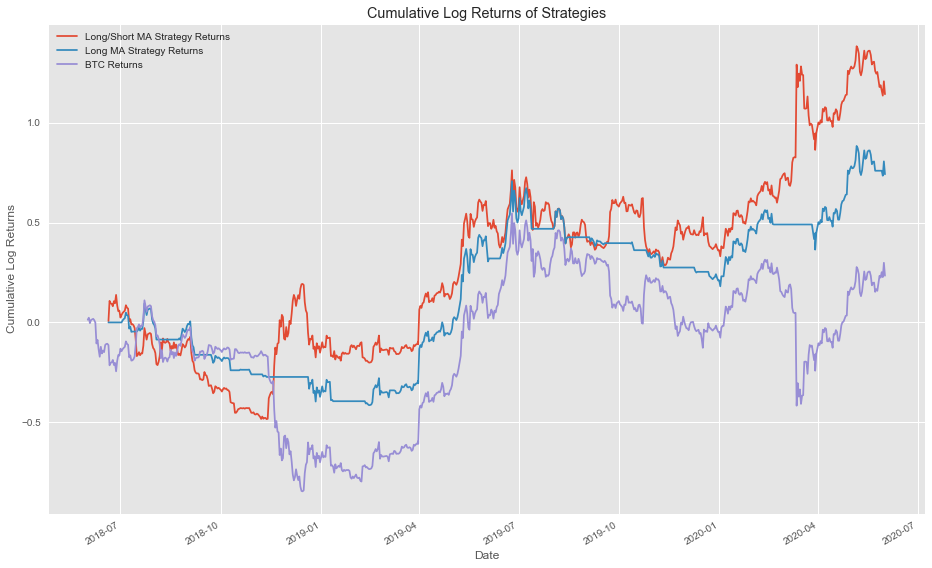

In [249]:
df_5_20['strategy_r'].cumsum().plot(figsize=(14,10),label='Long/Short MA Strategy Returns')
df_5_20['long_r'].cumsum().plot(label='Long MA Strategy Returns')
df_5_20['BTC_R'].cumsum().plot(label='BTC Returns')
plt.legend()
plt.ylabel('Cumulative Log Returns')
plt.title('Cumulative Log Returns of Strategies')

The results of the strategies vs the buy and hold Bitcoin strategy are listed below:

In [250]:
LS_R = round( (expm1(df_5_20['strategy_r'].sum()) * 100) / 2, 2)
LONG_R = round( (expm1(df_5_20['long_r'].sum()) * 100) / 2, 2)
BTC_R = round( (expm1(df_5_20['BTC_R'].sum()) * 100) / 2, 2)

print('Long & Short Moving Average Strategy Annual Returns: ' + str(LS_R) + '%')
print('Long Only Moving Average Strategy Annual Returns ' + str(LONG_R) + '%')
print('Buy and Hold Bitcoin Annual Returns ' + str(BTC_R)+ '%')

Long & Short Moving Average Strategy Annual Returns: 106.8%
Long Only Moving Average Strategy Annual Returns 55.0%
Buy and Hold Bitcoin Annual Returns 13.18%


Text(0, 0.5, 'Annualised Return (%)')

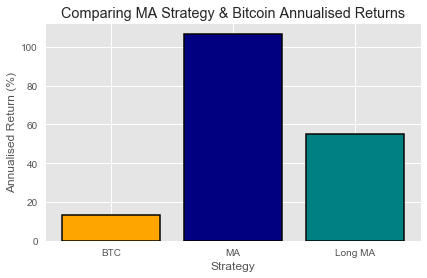

In [251]:
strats = ['BTC','MA', 'Long MA']
returns = [BTC_R, LS_R, LONG_R]
colors = ['orange', 'navy', 'teal']

plt.bar(strats,returns,color=colors,edgecolor='black',lw=1.5)
plt.title('Comparing MA Strategy & Bitcoin Annualised Returns')
plt.xlabel('Strategy')
plt.ylabel('Annualised Return (%)')

These technical trading strategies continue to generate excess returns, which is a sign that the market for Bitcoin is not weak-form efficient.

The excess returns generated from this moving average strategy outperformed the buy and hold benchmark for Bitcoin over the same period.

It should be noted that these returns do not take in to account the transaction costs involved with trading Bitcoin. Transaction costs on cryptocurrency exchanges are typically between 0.1 and 0.3 percent per trade.

In my previous research, introducting a transaction cost of 0.25 percent per trade reduced the profitability of the 5-20 Moving Average strategy but the strategy remained significantly profitable.

## Trading Range Break Strategy
A trading range break strategy uses the minimum and maximum values (i.e. the trading range) of a time series over a certain lookback period to generate  abuy or sell signal using the current price.

A buy signal is generated if the current price exceeds the maximum value over the previous 'n' trading days.

A sell signal is generated is the current price falls below the minimum value over the previous 'n' trading days.

Once a signal is generated, a long or short position is opened and held for a fixed period of 10 days before being closed and realising any gains or losses.

In this case, the trading range is equal to 50 days.

In [252]:
df_tr_50 = df.copy()

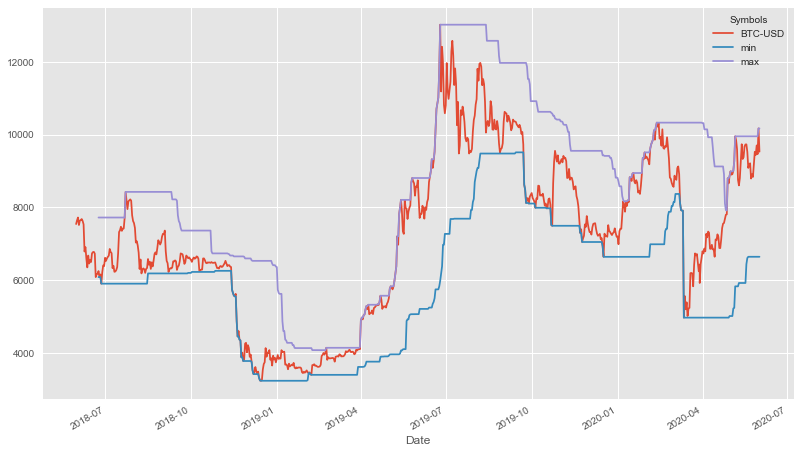

In [253]:
df_tr_50['BTC_R'] = np.log(df_tr_50['BTC-USD']).diff()
df_tr_50['min'] = df_tr_50['BTC-USD'].rolling(50,min_periods=25).min()
df_tr_50['max'] = df_tr_50['BTC-USD'].rolling(50,min_periods=25).max()
df_tr_50[['BTC-USD','min','max']].plot(figsize=(12,8))

Now that the maximum and minimum values for the 50-day ranges are calculated, a series of buy and sell signals can be generated.

In [254]:
df_tr_50['long'] = df_tr_50['BTC-USD'] == df_tr_50['max']
df_tr_50['short'] = df_tr_50['BTC-USD'] == df_tr_50['min']
df_tr_50['short'] = df_tr_50['short'] * -1
df_tr_50['signal'] = df_tr_50['long'] + df_tr_50['short']

In [255]:
df_tr_50['long'].sum()

56

In [256]:
df_tr_50['short'].sum()

-35

In total this trading strategy produces 56 buy signals and 35 sell signals over a two year period, resulting in 91 trades in total.

In [257]:
df_tr_50.head()

Symbols,BTC-USD,BTC_R,min,max,long,short,signal
Date,,,,,,,
2018-05-31,7541.450195,NaN,NaN,NaN,False,0,0
2018-06-01,7643.450195,0.013435,NaN,NaN,False,0,0
2018-06-02,7720.250000,0.009998,NaN,NaN,False,0,0
2018-06-03,7514.470215,-0.027016,NaN,NaN,False,0,0
2018-06-04,7633.759766,0.015750,NaN,NaN,False,0,0


Since this trading strategy results in a trade that is held for a period of 10 days, it is possible that a trading signal is produced while another trade is currently in progress.

The maximum amount of trades which are open at the same time in this two year period is calculated below:

In [258]:
df_tr_50['long'].rolling(10).sum().max()

8.0

When the cumulative number of trades entered is plotted on a graph, we see that these trades do tend to be clustered around areas of rapid price movement:

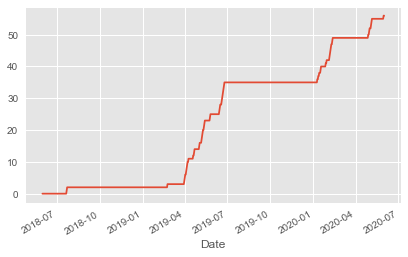

In [259]:
df_tr_50['long'].cumsum().plot(figsize=(6,4))

Since there can theoretically be 10 trades open at any given time, the maximum amount of investment into any given trade should be 10% of the total allocated to the strategy.

In [260]:
returns = []
for i in range(len(df_tr_50)-10):
    if df_tr_50['signal'].iloc[i] == 1:
        returns.append(np.log(df_tr_50['BTC-USD'][i+10] / df_tr_50['BTC-USD'][i]) * 0.1)
    elif df_tr_50['signal'].iloc[i] == -1:
        returns.append((np.log(df_tr_50['BTC-USD'][i+10] / df_tr_50['BTC-USD'][i])) * -0.1 )
    else:
        returns.append(0)

for i in range(10):
    returns.append(0)
        
df_tr_50['returns'] = returns

The returns series is shifted by 10 places to reflect the day the position is closed, rather than when it is entered

In [261]:
df_tr_50['returns'] = df_tr_50['returns'].shift(10)

The strategy log returns are plotted alongside the log returns for Bitcoin over the two year period to reflect the buy and hold strategy.

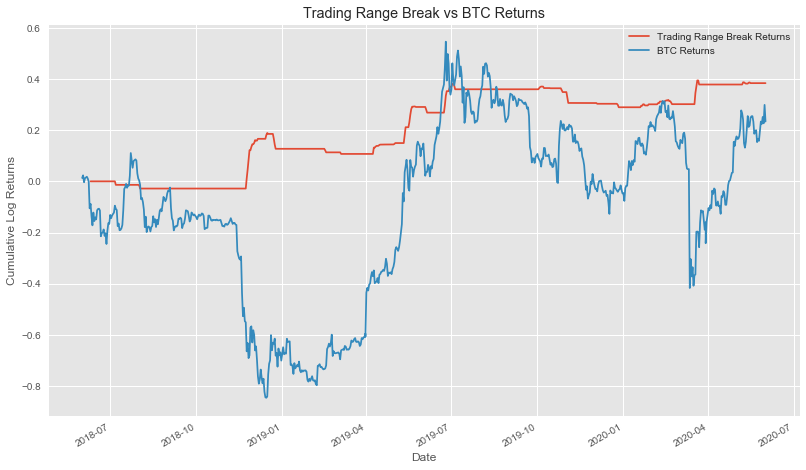

In [262]:
df_tr_50['returns'].cumsum().plot(figsize=(12,8),label='Trading Range Break Returns')
df_tr_50['BTC_R'].cumsum().plot(label='BTC Returns')
plt.title('Trading Range Break vs BTC Returns')
plt.ylabel('Cumulative Log Returns')
plt.legend()

Again, it may not be possible to short sell Bitcoin in practice, so the strategy returns for only long trading range break signals are calculated and added to the plot below.

In [263]:
long_r = []
for i in range(len(df_tr_50)-10):
    if df_tr_50['long'].iloc[i] == 1:
        long_r.append(np.log(df_tr_50['BTC-USD'][i+10] / df_tr_50['BTC-USD'][i]) * 0.1)
    else:
        long_r.append(0)

for i in range(10):
    long_r.append(0)
        
df_tr_50['long_r'] = long_r

In [264]:
df_tr_50['long_r'] = df_tr_50['long_r'].shift(10)

Text(0, 0.5, 'Cumulative Log Return')

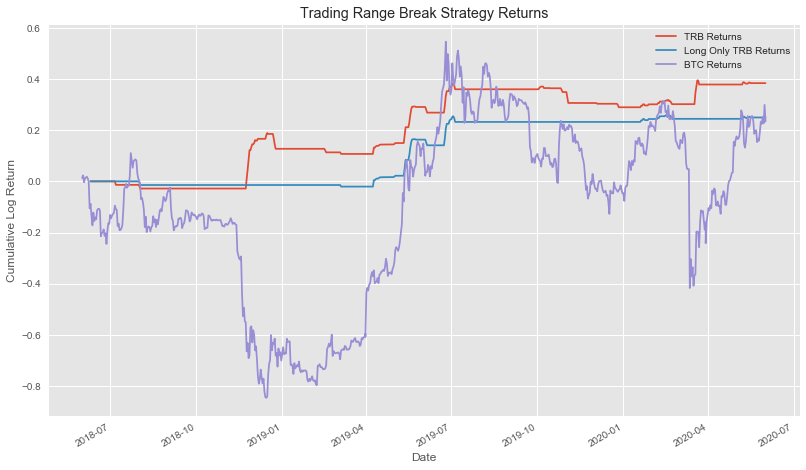

In [265]:
df_tr_50['returns'].cumsum().plot(figsize=(12,8),label='TRB Returns')
df_tr_50['long_r'].cumsum().plot(label='Long Only TRB Returns')
df_tr_50['BTC_R'].cumsum().plot(label='BTC Returns')
plt.legend()
plt.title('Trading Range Break Strategy Returns')
plt.ylabel('Cumulative Log Return')

The results of these strategies vs the buy and hold strategy for Bitcoin are provided below:

In [266]:
trb_r = round((expm1(df_tr_50['returns'].sum()) * 100) / 2, 2)
long_r = round((expm1(df_tr_50['long_r'].sum()) * 100) / 2, 2)
btc_r = round((expm1(df_tr_50['BTC_R'].sum()) * 100) / 2)

print('Annual Return of Long & Short TRB Strategy = ' + str(trb_r) + '%')
print('Annual Return of Long Only TRB Strategy = ' + str(long_r) + '%')
print('Annual Return of Buy and Hold Bitcoin = ' + str(btc_r) + '%')

Annual Return of Long & Short TRB Strategy = 23.39%
Annual Return of Long Only TRB Strategy = 14.18%
Annual Return of Buy and Hold Bitcoin = 13%


Trading Range Break strategies generated small excess returns over the buy and hold benchmark for Bitcoin during this two year period.

When this strategy was reduced to the 'long-only' format, it generated nearly identical returns to the buy and hold benchmark over the two year period.

It should be noted once again that this does not take into consideration transaction costs which are between 0.1 and 0.3 percent per trade on most cryptocurrency exchanges.

## Alternate Trading Range Break Strategy
Instead of limiting this strategy to only investing 10% into any given trade, it can be altered to allocate 100% of the investment into each trade by limiting it to only having one open trade at any given time. The results from this technique are explored below.

In [267]:
alt_sig = []
last_sig = 11

for i in range(len(df_tr_50)-10):
    if last_sig < 10:
        alt_sig.append(0)
        last_sig += 1
    else:
        if df_tr_50['BTC-USD'][i] == df_tr_50['max'][i]:
            alt_sig.append(1)
            last_sig = 0
        elif df_tr_50['BTC-USD'][i] == df_tr_50['min'][i]:
            alt_sig.append(-1)
            last_sig = 0
        else:
            alt_sig.append(0)
            last_sig += 1
        
for i in range(10):
    alt_sig.append(0)       

In [268]:
df_tr_50['alt_sig'] = alt_sig

In [269]:
df_tr_50['alt_sig_long'] = df_tr_50['alt_sig'] + 1
df_tr_50['alt_sig_long'] = np.sign(df_tr_50['alt_sig_long'])

In [270]:
alt_sig_r = []
for i in range(len(df_tr_50)-10):
    if df_tr_50['alt_sig'].iloc[i] != 0:
        alt_sig_r.append(np.log(df_tr_50['BTC-USD'][i+10] / df_tr_50['BTC-USD'][i]) * df_tr_50['alt_sig'].iloc[i])
    else:
        alt_sig_r.append(0)
        
for i in range(10):
    alt_sig_r.append(0)
    
df_tr_50['alt_sig_r'] = alt_sig_r

In [271]:
df_tr_50['alt_sig_r'] = df_tr_50['alt_sig_r'].shift(10)

Text(0, 0.5, 'Cumulative Log Return')

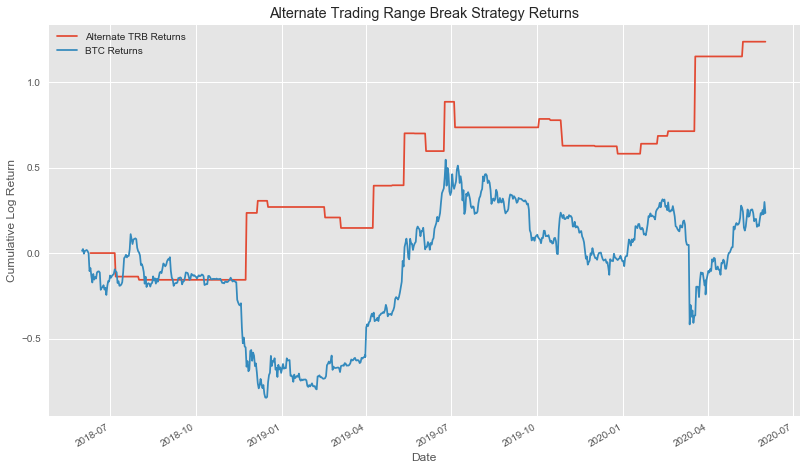

In [272]:
df_tr_50['alt_sig_r'].cumsum().plot(figsize=(12,8),label='Alternate TRB Returns')
df_tr_50['BTC_R'].cumsum().plot(label='BTC Returns')
plt.legend()
plt.title('Alternate Trading Range Break Strategy Returns')
plt.ylabel('Cumulative Log Return')

This strategy performs better than the trading range break strategy where each trade was allocated a maximum of 10% of the total investment.

As with the previous strategy, the returns for only the long positions are also calculated due to the difficulty in short selling cryptocurrencies.

In [273]:
alt_sig_long_r = []
for i in range(len(df_tr_50)-10):
    if df_tr_50['alt_sig'].iloc[i] == 1:
        alt_sig_long_r.append(np.log(df_tr_50['BTC-USD'][i+10] / df_tr_50['BTC-USD'][i]) * df_tr_50['alt_sig'].iloc[i])
    else:
        alt_sig_long_r.append(0)
        
for i in range(10):
    alt_sig_long_r.append(0)
    
df_tr_50['alt_sig_long_r'] = alt_sig_long_r

Text(0, 0.5, 'Cumulative Log Return')

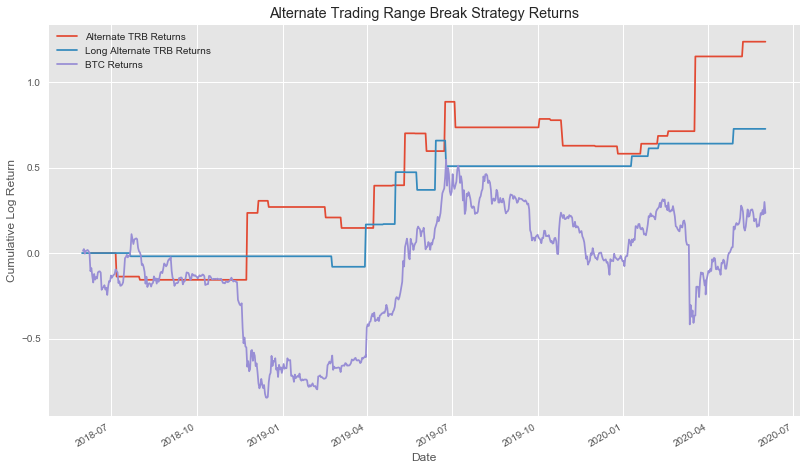

In [274]:
df_tr_50['alt_sig_r'].cumsum().plot(figsize=(12,8),label='Alternate TRB Returns')
df_tr_50['alt_sig_long_r'].cumsum().plot(label='Long Alternate TRB Returns')
df_tr_50['BTC_R'].cumsum().plot(label='BTC Returns')
plt.legend()
plt.title('Alternate Trading Range Break Strategy Returns')
plt.ylabel('Cumulative Log Return')

Annualised returns for the original and alternate trading range break strategies are calculated and compared to the buy and hold benchmark for bitcoin below:

In [275]:
trb_r = round((expm1(df_tr_50['returns'].sum()) * 100) / 2, 2)
long_r = round((expm1(df_tr_50['long_r'].sum()) * 100) / 2, 2)
btc_r = round((expm1(df_tr_50['BTC_R'].sum()) * 100) / 2)

print('Annual Return of Long & Short TRB Strategy = ' + str(trb_r) + '%')
print('Annual Return of Long Only TRB Strategy = ' + str(long_r) + '%')
print()
print('Annual Return of Buy and Hold Bitcoin = ' + str(btc_r) + '%')
print()

alt_trb_r = round((expm1(df_tr_50['alt_sig_r'].sum()) * 100) / 2, 2)
alt_long_r = round((expm1(df_tr_50['alt_sig_long_r'].sum()) * 100) / 2, 2)

print('Annual Return of Alternate Long & Short TRB Strategy = ' + str(alt_trb_r) + '%')
print('Annual Return of Alternate Long Only TRB Strategy = ' + str(alt_long_r) + '%')

Annual Return of Long & Short TRB Strategy = 23.39%
Annual Return of Long Only TRB Strategy = 14.18%

Annual Return of Buy and Hold Bitcoin = 13%

Annual Return of Alternate Long & Short TRB Strategy = 122.03%
Annual Return of Alternate Long Only TRB Strategy = 53.34%


Text(0, 0.5, 'Annualised Return (%)')

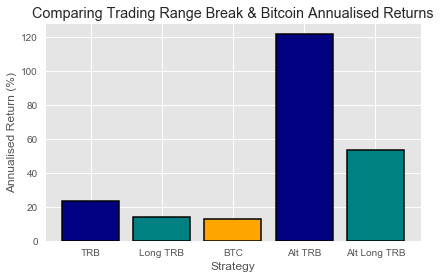

In [276]:
strats = ['TRB','Long TRB','BTC','Alt TRB', 'Alt Long TRB']
returns = [trb_r, long_r, btc_r, alt_trb_r, alt_long_r]
colors = ['navy', 'teal', 'orange', 'navy', 'teal']

plt.bar(strats,returns,color=colors,edgecolor='black',lw=1.5)
plt.title('Comparing Trading Range Break & Bitcoin Annualised Returns')
plt.xlabel('Strategy')
plt.ylabel('Annualised Return (%)')

The Alternate trading range break strategy whereby only one position can be entered at a time, greatly outperforms both the original trading range break strategy and the buy and hold benchmark for Bitcoin. This is the case for both the long and short strategy, as well as the strategy which only opens long positions.

## Summary
I have taken two of the profitable trading strategies which were identified during my dissertation in 2018 and applied their rules to Bitcoin for the two years following the completion of my original study.

I have found that a moving average crossover strategy of SMA 5 and LMA 20 continued to produce excess returns above the Bitcoin buy and hold benchmark. The 'long-only' moving average strategy produced 55% annualised returns over this two year period.

I have also found that a trading range break strategy with a lookback period of 50 days applied to Bitcoin does not generate significant excess returns when multiple positions are able to be held at once. Once this strategy is altered to only ennter one position at a time however, it does generate significant excess reutrns over the Bitcoin buy and hold benchmark. The 'long-only' alternate trading range break strategy generated annualised returns of 53% over this two year period.

The fact that these strategies are still profitable two years after my original research suggests that themarket for Bitcoin is still not weak-form efficient; excess returns can be generated by following mathematical trends in the price of the underlying asset.

Future studies can again build upon my original research and expand this testing out to filter rules and general momentum strategies.